Now we have data from OpenNeuro in BIDS format, including derivatives such as preprocessed images and confounds(fMRIPrep).
You can look around in the directory to see what files are in our dataset.

In [1]:
import os
import glob
import nilearn
import json
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
import matplotlib.pyplot as plt
import datalad.api as dl

/Users/sunjaeshim/opt/anaconda3/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
bids_dir = '/Users/sunjaeshim/Documents/GitHub/BrainHack2023_fMRI_practice/ds001734/'
fmriprep_dir = bids_dir + 'derivatives/fmriprep/'

#You can change the subjects you want to analyze.
some_subjects = ['sub-001']
#If you want to analyze all data, you can save all subject ids in this dataset by using glob
#Note this will take much much longer and I wouldn't recommend running at the moment
all_files = glob.glob(bids_dir+'sub-*')
all_subjects = sorted([os.path.basename(i) for i in all_files])

We will need event files, preprocessed images files, and confound files in order to build our design matrix. You can create a function to get the corresponding files. 

Note:
1. There are several runs per subject, so make sure you are organizing the correct files together.
2. You will have to get the files from datalad. You can do this by running 'dl.get(filename)'


In [3]:
def get_files(sub, run):
    run = str(run)
    
    event_file = glob.glob(bids_dir+sub+f'/func/*run-0{run}*.tsv')[0]
    
    func_file = glob.glob(fmriprep_dir+sub+f'/func/*task-MGT*run-0{run}*preproc.nii.gz')[0]
    
    confounds_file = glob.glob(fmriprep_dir+sub+f'/func/*task-MGT*run-0{run}*confounds*')[0]
    
    return event_file, func_file, confounds_file

We will also need to know the TR (repetition time) of the scans. You can get this information from the BIDS scan json file

In [4]:
def get_tr(bids_dir):
    json_file = glob.glob(bids_dir+'*task*.json')[0]
    f = open(json_file)
    data = json.load(f)
    tr = data['RepetitionTime']
    return tr

You can choose which confound regressors to add to the analysis. You can take a look at the confounds output to evaluate what you would include to denoise the scans. 

More information about confound outputs from fMRIPrep: https://fmriprep.org/en/stable/outputs.html#confounds

In [5]:
def get_confounds(confounds_file):
    confounds_df = pd.read_csv(confounds_file, sep='\t')
    #These are the very basic confounds most recommend. Adding the derivatives of these may also improve
    #Newer versions of fMRIPrep gives you derivatives
    #Note if you add CompCor components, you also should use the fMRIPrep cosine regressors instead of nilearn's
    confounds_df  = confounds_df[['FramewiseDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']]
    
    return confounds_df

In [6]:
def create_contrasts(design_matrix):
    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i]) for i, column in enumerate(design_matrix.columns)])
    contrasts = {
        'strongly accept - strongly reject': basic_contrasts['strongly_accept'] - basic_contrasts['strongly_reject'],
        'weakly accept - weakly reject': basic_contrasts['weakly_accept'] - basic_contrasts['weakly_reject'],
    }
    return contrasts

sub-001/ses-1


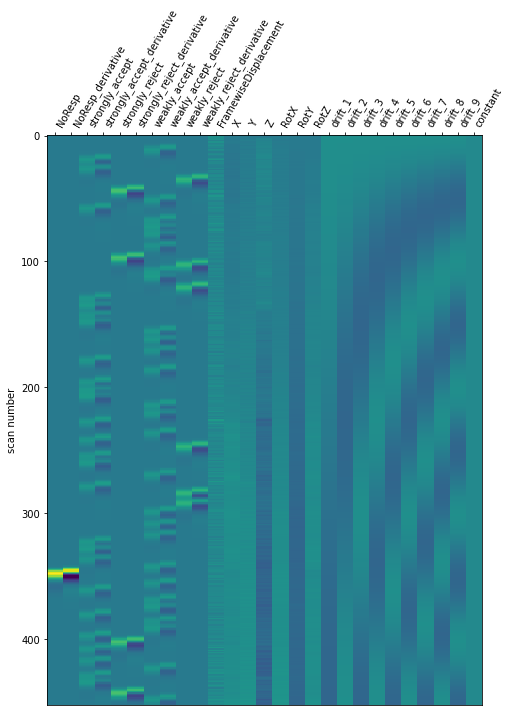

/Users/sunjaeshim/opt/anaconda3/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


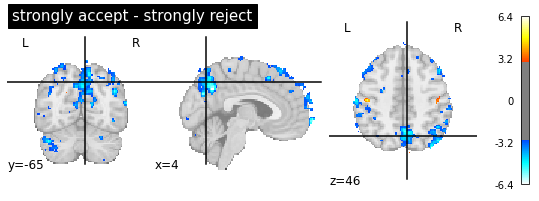

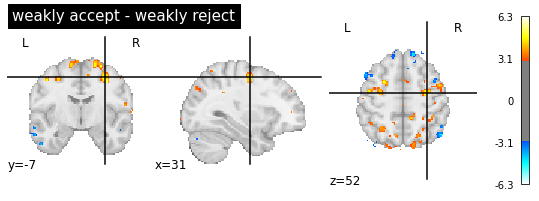

sub-001/ses-2


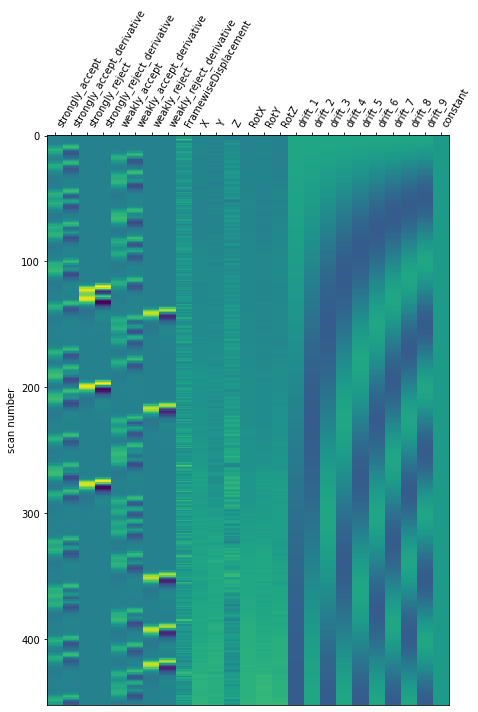

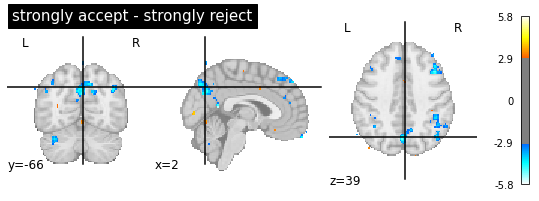

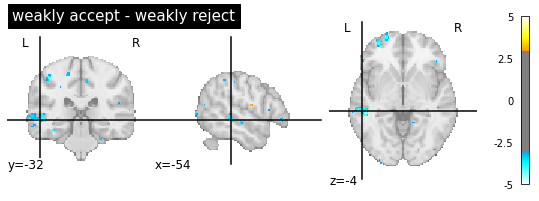

sub-001/ses-3


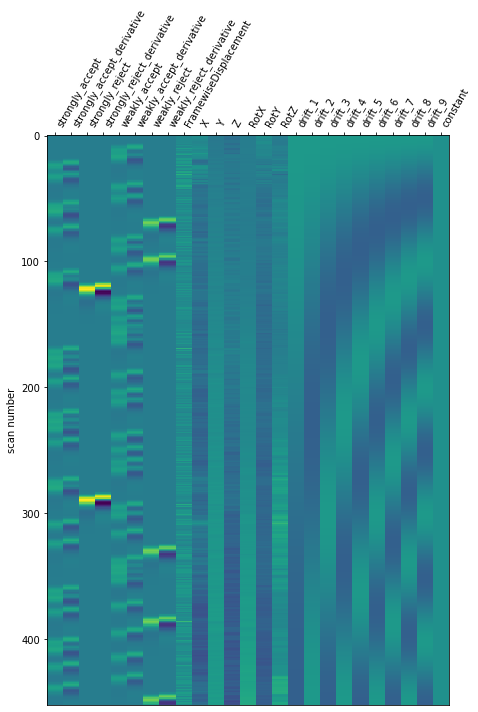

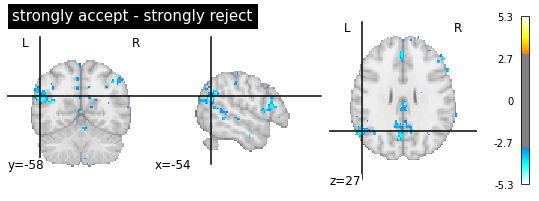

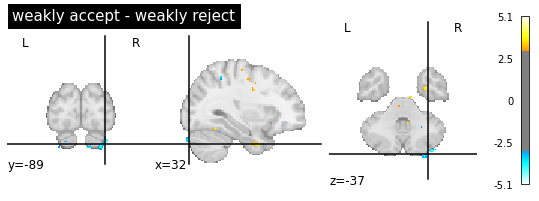

sub-001/ses-4


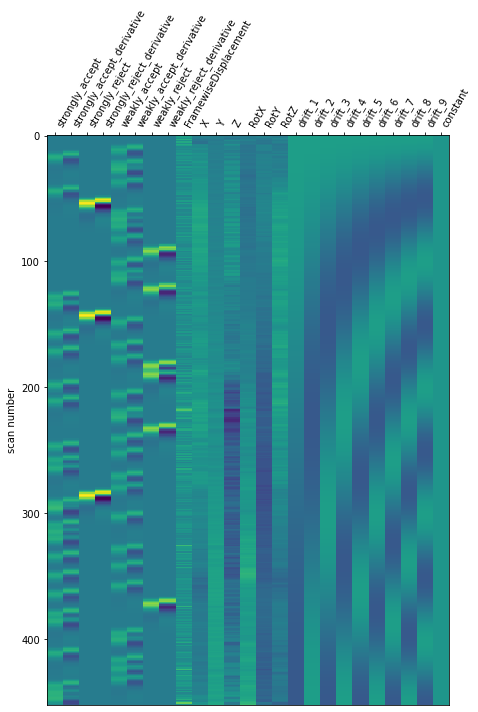

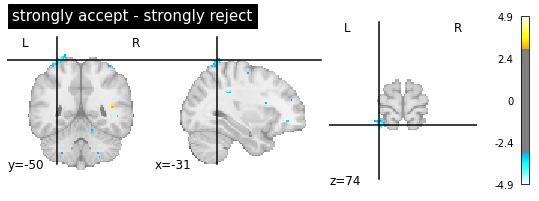

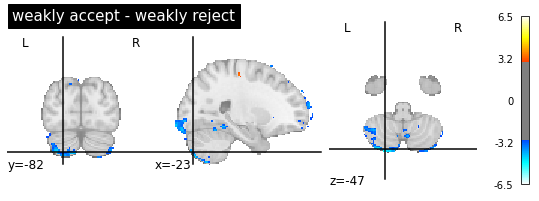

In [7]:
tr = get_tr(bids_dir)
for sub in some_subjects:
    for i in range(1,5):
        event_file, func_file, confounds_file = get_files(sub, i)
        
        #get files from datalad
        dl.get(event_file)
        dl.get(func_file) 
        dl.get(confounds_file)
        
        events = pd.read_csv(event_file, sep='\t')[['participant_response', 'onset', 'duration']]
        events.rename(columns = {'participant_response':'trial_type'}, inplace=True)
        confounds = get_confounds(confounds_file)
        confounds = confounds.fillna(0)
        first_level_model = FirstLevelModel(tr, hrf_model = 'spm + derivative', smoothing_fwhm=5)
        first_level_model = first_level_model.fit(func_file, events=events, confounds=confounds)        
        design_matrix = first_level_model.design_matrices_[0]
        #show design matrix
        print(f'{sub}/ses-{i}')
        plotting.plot_design_matrix(design_matrix)
        plt.show()
        
        contrasts = create_contrasts(design_matrix)
        #show contrast maps
        for contrast_id, contrast_val in contrasts.items():
            z_map = first_level_model.compute_contrast(
                    contrast_val, output_type = 'z_score'
                    )
            plotting.plot_stat_map(
                    z_map, threshold=3.0, title=contrast_id)
            plotting.show()